# Plot the model outputs

In [1]:
import pandas as pd
from simpler_mpl import set_common_mpl_styles
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import matplotlib.pyplot as plt
from simpler_pandas import apply_labelling, sanity_check, show_df_details
from labelling import format_to_base_10

In [2]:
MARKETING_COST_PER_INSURED = 20
VALUE_PER_RETAINED_CONTRACT = 1000

uplift_result_file = "df_comparison_uplift.pickle"
df_comparison_uplift = pd.read_pickle(uplift_result_file)
churn_result_file = "df_comparison_churn.pickle"
df_comparison_churn = pd.read_pickle(churn_result_file)
dummy_result_file = "df_comparison_dummy.pickle"
df_comparison_dummy = pd.read_pickle(dummy_result_file)

df_to_plot = pd.concat((df_comparison_dummy, df_comparison_churn, df_comparison_uplift), axis=1)

def check_series_is_ordered(ser, ascending=True):
    """Check 1 series is ascending"""
    assert ascending==True, "Haven't done descending yet, nor tested this"
    return (ser.shift()[1:].reset_index(drop=True) >= ser[:-1].reset_index(drop=True)).all()

assert check_series_is_ordered(df_to_plot['churn_proba_pos'])
assert check_series_is_ordered(df_to_plot['dummy_proba_pos'])
assert check_series_is_ordered(df_to_plot['uplift_diff_t_c'])

df_to_plot

,dummy_proba_pos,dummy_will_churn,churn_proba_pos,churn_will_churn,uplift_diff_t_c,uplift_will_churn
0,0.16582,0,0.391900,0,-0.315099,0
1,0.16582,1,0.391900,0,-0.315099,0
2,0.16582,0,0.391900,0,-0.315099,0
3,0.16582,0,0.391900,0,-0.315099,0
4,0.16582,0,0.391900,0,-0.315099,0
...,...,...,...,...,...,...
49995,0.16582,1,0.025328,0,0.237179,0
49996,0.16582,0,0.025328,1,0.237179,1
49997,0.16582,1,0.025328,0,0.237179,1
49998,0.16582,0,0.025328,0,0.237179,1


In [3]:
sanity_check(df_to_plot)
show_df_details(df_to_plot)

is view False, is consolidated False, single block False, numeric mixed True
6 blocks looking like:
(NumericBlock: slice(0, 1, 1), 1 x 50000, dtype: float64, NumericBlock: slice(1, 2, 1), 1 x 50000, dtype: int64, NumericBlock: slice(2, 3, 1), 1 x 50000, dtype: float64, NumericBlock: slice(3, 4, 1), 1 x 50000, dtype: int64, NumericBlock: slice(4, 5, 1), 1 x 50000, dtype: float64, NumericBlock: slice(5, 6, 1), 1 x 50000, dtype: int64)


In [4]:
def calculate_value_generated(dfx, col_will_churn, model_name):
    # assume we're sorted
    #df_costing = dfx.sort_values(col, ascending=ascending).copy().reset_index(drop=True)
    df_costing = dfx[[col_will_churn]].copy()
    #df_costing['price_if_mktd'] = -1
    #df_costing['price_if_mktd_cumsum'] = df_costing['price_if_mktd'].cumsum()
    #df_costing['price_if_retained'] = 1000 * (df_costing[col_will_churn]==0)
    value_column = f"{model_name}_value"
    df_costing[value_column] = (VALUE_PER_RETAINED_CONTRACT * (df_costing[col_will_churn]==0)) - MARKETING_COST_PER_INSURED
    value_column_cumsum = f"{model_name}_value_cumsum"
    df_costing[value_column_cumsum] = df_costing[value_column].cumsum()
    return df_costing[[value_column, value_column_cumsum]]

df_costing_uplift = calculate_value_generated(df_to_plot, "uplift_will_churn", "uplift")
#df_costing.iloc[10000]
df_costing_uplift

,uplift_value,uplift_value_cumsum
0,980,980
1,980,1960
2,980,2940
3,980,3920
4,980,4900
...,...,...
49995,980,40598080
49996,-20,40598060
49997,-20,40598040
49998,-20,40598020


In [5]:
df_costing_churn = calculate_value_generated(df_to_plot, "churn_will_churn", "churn")

In [6]:
df_costing_dummy = calculate_value_generated(df_to_plot, "dummy_will_churn", "dummy")

In [16]:
df_to_plot = pd.concat((df_costing_dummy, df_costing_churn, df_costing_uplift), axis=1)
df_to_plot.sample(5).sort_index()

,dummy_value,dummy_value_cumsum,churn_value,churn_value_cumsum,uplift_value,uplift_value_cumsum
11021,-20,9006560,980,7373560,980,10200560
16825,980,13714480,980,12509480,-20,15269480
27303,-20,22189920,980,21152920,-20,24135920
38397,980,31187040,980,29759040,980,33067040
46847,980,38047040,980,37627040,-20,38654040


In [10]:
row_with_minimum_uplift_effect = (0 - df_comparison_uplift['uplift_diff_t_c'].abs()).idxmax()
row_with_minimum_uplift_effect
print(f"By insured {row_with_minimum_uplift_effect:,} the Uplift model predicts subsequent rows will respond neutrally or negatively to this campaign")
print(f"By this point we've incurred a marketing cost of ${MARKETING_COST_PER_INSURED * row_with_minimum_uplift_effect:,}.")
df_to_plot.loc[row_with_minimum_uplift_effect]

By insured 21,210 the Uplift model predicts subsequent rows will respond neutrally or negatively to this campaign
By this point we've incurred a marketing cost of $424,200.


dummy_value                 -20
dummy_value_cumsum     17227780
churn_value                 980
churn_value_cumsum     16115780
uplift_value                980
uplift_value_cumsum    19112780
Name: 21210, dtype: int64

In [11]:
df_to_plot['dummy_value_cumsum'] = df_to_plot['dummy_value_cumsum'] / 1_000_000
df_to_plot['churn_value_cumsum'] = df_to_plot['churn_value_cumsum'] / 1_000_000
df_to_plot['uplift_value_cumsum'] = df_to_plot['uplift_value_cumsum'] / 1_000_000

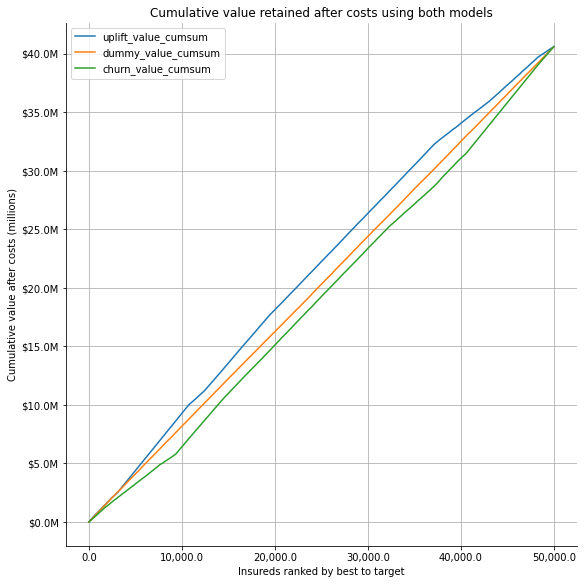

In [12]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
df_to_plot[:50_000].plot(y=['uplift_value_cumsum', 'dummy_value_cumsum', 'churn_value_cumsum'], ax=ax);
title = "Cumulative value retained after costs using both models"
set_common_mpl_styles(ax, grid_axis="both", xlabel="Insureds ranked by best to target", 
                      ylabel="Cumulative value after costs (millions)", title=title)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:}M'))

In [13]:
quantile = pd.cut(df_to_plot.index, 5, right=False)
quantile

[[0.0, 9999.8), [0.0, 9999.8), [0.0, 9999.8), [0.0, 9999.8), [0.0, 9999.8), ..., [39999.2, 50048.999), [39999.2, 50048.999), [39999.2, 50048.999), [39999.2, 50048.999), [39999.2, 50048.999)]
Length: 50000
Categories (5, interval[float64, left]): [[0.0, 9999.8) < [9999.8, 19999.6) < [19999.6, 29999.4) < [29999.4, 39999.2) < [39999.2, 50048.999)]

In [14]:
mean_result_by_quantile = df_to_plot.groupby(quantile)[['uplift_value', 'dummy_value', 'churn_value']].mean()
mean_result_by_quantile.index = apply_labelling(mean_result_by_quantile.index, format_to_base_10)
mean_result_by_quantile

,uplift_value,dummy_value,churn_value
[0.00 - 10.00k),929.1,818.2,641.3
[10.00k - 20.00k),884.0,807.7,869.9
[20.00k - 30.00k),823.2,813.4,825.5
[30.00k - 40.00k),769.2,811.3,770.0
[40.00k - 50.05k),654.4,809.3,953.2


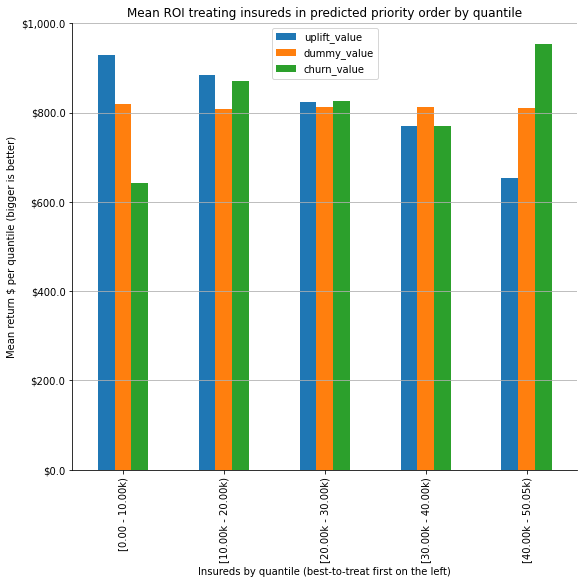

In [15]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
mean_result_by_quantile.plot(kind='bar', ax=ax)
title = "Mean ROI treating insureds in predicted priority order by quantile"
set_common_mpl_styles(ax, grid_axis="y", xlabel="Insureds by quantile (best-to-treat first on the left)", title=title, ylabel="Mean return $ per quantile (bigger is better)")
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,}'))